<a href="https://colab.research.google.com/github/hhtt67678/ML_with_Pytorch/blob/main/04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Notebook.

How to get my own data into PyTorch for my own projects?

One way is via *custom datasets*.

## Domain Libraries.

PyTorch has existing dataloading libraries for some datatypes (audio, vision, video, text, recommendations, etc.).

For this project we will be building a Food Vision classifier.

## 0. Importing the things we'll need.

In [ ]:
import torch
from torch import nn

import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.0.0+cu118'

In [ ]:
# device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# check GPU type

# !nvidia-smi

## 1. Get Data

Data is a subset of the Food101 dataset. Starts with 101 classes of food and 1000 images per class ( 750 training, 250 testing).

Our dataset has 3 classes of food and 10% of the images.

Important: start small, and increase scale when necessary. This enables faster experimentation before training on large dataset.


In [ ]:
import requests
import zipfile
from pathlib import Path

# set up path to data folder

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If image folder doesn't exist, create one and download data

if image_path.is_dir():
  print(f'{image_path} already exists, skipping download')
else:
  print(f'{image_path} does not exist, creating...')
  image_path.mkdir(parents=True, exist_ok=True)


# dl data from github (note specific file structure in the zip file for images/type/testing/etc...)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('downloading data...')
  f.write(request.content)

# unzip file once downloaded

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('unzipping data...')
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating...
downloading data...
unzipping data...


## 2. Data Preparation and Exploration

In [ ]:
# explore data by walking through directoreis and see what's happening

import os


def walk_through_dir(dir_path):
  '''walk through dir_path returning its contents'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [ ]:
# set up training and test paths

train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image

random image path: data/pizza_steak_sushi/test/steak/690177.jpg
image class: steak
height: 512
width: 382


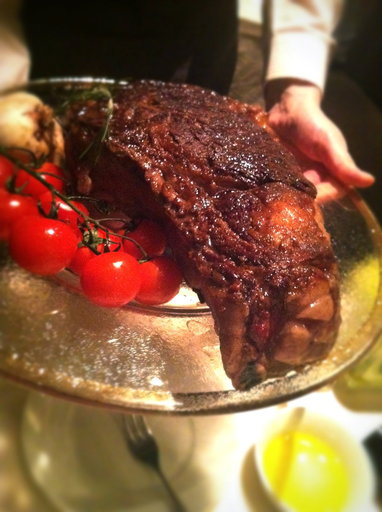

In [ ]:
import random
from PIL import Image

# for reproducibility
# random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))

# pick random image path

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

# note there is read_image in PyTorch

img = Image.open(random_image_path)

print(f'random image path: {random_image_path}')
print(f'image class: {image_class}')
print(f'height: {img.height}')
print(f'width: {img.width}')
img

Image class: pizza
Image shape: (512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

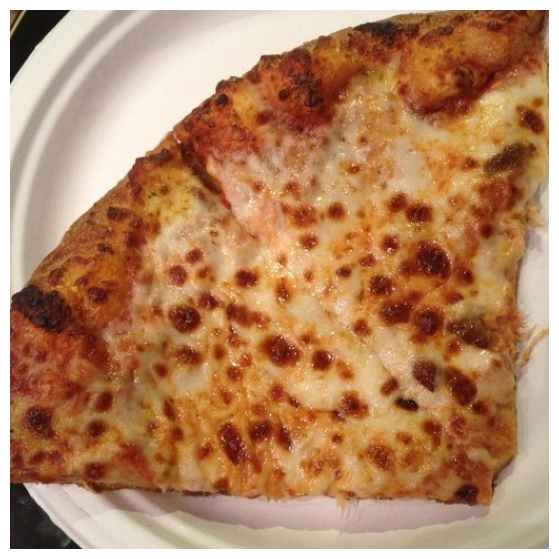

In [ ]:
# Visualize image using MatPlotLib as alternative
# convert to numpy array

import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array

im_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(im_array)
print(f'Image class: {image_class}\nImage shape: {im_array.shape}')
plt.axis(False)

## 3. Transforming data.

Get data into tensor format with PyTorch, then turn into `torch.utils.data.Dataset` and then into `torch.data.DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transform`



In [ ]:
# Write a transform for image by sequencing several torchvision.transforms

data_transform = transforms.Compose([
    # Resize images to standard size
    transforms.Resize(size=(64, 64)),
    # Flip images randomly 
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into torch tensor
    transforms.ToTensor()]
    )

In [ ]:
y = data_transform(img) # takes in PIL image

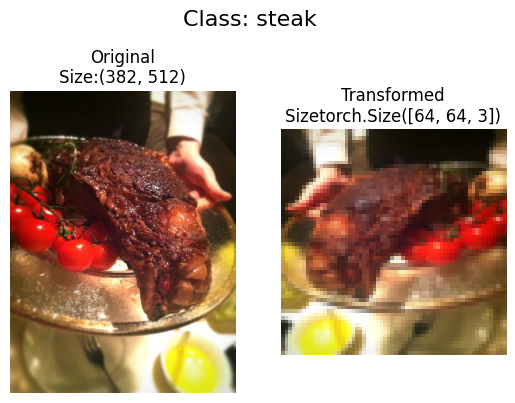

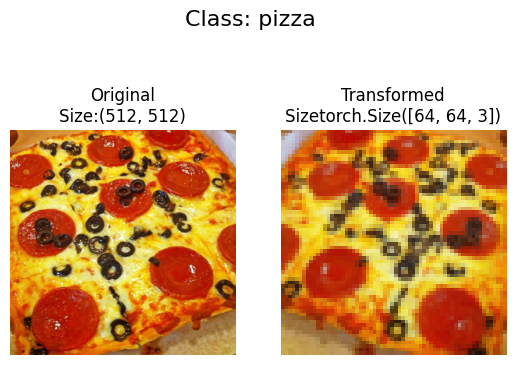

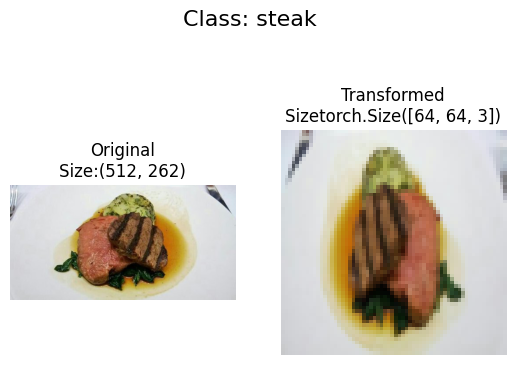

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  '''docstring'''
  if seed:
    random.seed(seed)
  
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize:{f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize{transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                        transform=data_transform,
                        seed=765)


In [ ]:
test_dir, train_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

## 4. Take the training data and transform it into something that PyTorch can use.

Use `datasets.ImageFolder` to create a dataset for PyTorch. Assume the data is organized into 
`folder/train/class` structure.

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, # folder for target images
                                  transform=data_transform, # transform images
                                  target_transform=None) # perform transforms on targets, if needed

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [ ]:
# Is now a PyTorch dataset, can apply same methods as before.
# Get class names for training data
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
data, label = train_data[0][0], train_data[0][1]
print(f'Img tensor: {data}')
print(f'Img datatype: {data.dtype}')
print(f'Img shape: {data.shape}')
print(f'Img label: {label}')
print(f'label dtype: {type(label)}')

Img tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157

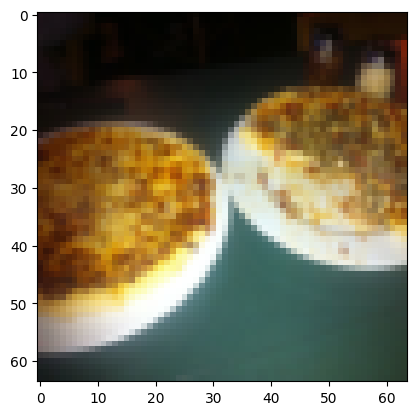

In [ ]:
# Plot the image
plt.imshow(np.asarray(data.permute(1, 2, 0)))

In [ ]:
# Obvious but reducing the image size reduces the ability to recognize it. in this case the 

## 4.1 Turn data into dataloaders.

`torch.utils.data.DataLoader` as used before turns the dataset into an interable 
that can be batched and fed into the neural network.

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)


In [ ]:
train_dataloader

In [ ]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Creating your custom datasets

Create a custom dataset by subclassing the `torch.utils.data.Dataset` class.

1. Use python tools to write helper function to get class names from images.
2. Create a subclass of `torch.utils.data.Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
target_directory = train_dir
target_directory

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
[entry.name for entry in list(os.scandir(target_directory))]

['steak', 'pizza', 'sushi']

In [ ]:
# write helper function to do the above

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  
  classes = [entry.name for entry in list(os.scandir(directory))]

  if not classes:
    raise FileNotFoundError(f'Could not find any classes in {directory}')
  
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['steak', 'pizza', 'sushi'], {'steak': 0, 'pizza': 1, 'sushi': 2})

## Create a custom `Dataset` class to replicate the `ImageFolder` object.

1. Subclass `torch.utils.data.Dataset`
2. Initialize the subclass with `targ_dir` parameter and `transform` parameter.
3. Create `path` attributes, `transforms`, `classes`, and `class_to_idx` (some of these may be `None`)
4. Create function to load images from file and return them using `PIL` or `torchvision.io`
5. Overwrite `__len__` method (recommended)
6. Overwrite `__getitem__` method (required)

In [ ]:
class ImageFolderCustom(Dataset):

  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) # Attribute: paths
    self.transform = transform # transform to apply to images
    self.classes, self.class_to_idx = find_classes(targ_dir) # helper function to find classes and make dictionary of classes and idx
  
  # load image: given index, load image and return the loaded image
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)
  
  # overwrite len method - attribute gives number of paths (images)
  def __len__(self) -> int:
    return len(self.paths)

  
  # overwrite getitem: 
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else: 
      return img, class_idx



In [ ]:
# write transform functions using transforms.Compose

train_transform = transforms.Compose([
    # Resize images to standard size
    transforms.Resize(size=(64, 64)),
    # Flip images randomly 
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into torch tensor
    transforms.ToTensor()]
    )

test_transform =  transforms.Compose([
    # Resize images to standard size
    transforms.Resize(size=(64, 64)),
    # Flip images randomly - training only 
    # transforms.RandomHorizontalFlip(p=0.5),
    #turn image into torch tensor
    transforms.ToTensor()]
    )

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=target_directory,
                                    transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                         transform=test_transform)

In [ ]:
# Test to see if the two loaded datasets are equal.

print(f'Test: same size datasets? {len(train_data) == len(train_data_custom) and len(test_data) == len(test_data_custom)}')
print(f'Test: same classes? {train_data.classes == train_data_custom.classes}')
print(f'Test: same class_to_idx? {train_data.class_to_idx == train_data_custom.class_to_idx}')

Test: same size datasets? True
Test: same classes? False
Test: same class_to_idx? False


## 5.3 Lets Create a function to display come random images.

Create a helper function `display_random_images()` that will:
1. Take a dataset and some parameters (classes, number of images, random seed).
2. Get a list of n random sample indexes (cap n at 10)
3. Set up a `matplotlib` plot.
4. Loop through the randomly chosen images and plot them.
5. Make sure the images are of shape HWC.

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
  
  '''
  Randomly choose images frrom a dataset and displays them.
  
  dataset: a torch.utils.data.Dataset
  classes(optional): list, classes to chose from.
  n: int, number of images to display (max 10)
  display shape: bool, ???
  seed: int, for reproducibility
  '''

  # Set n=10 as cap
  if n > 10:
    n = 10
    display_shape = False
    print(f'Too many images, setting n=10')
  
  # set random seed
  if seed:
    random.seed(seed)
  
  # get random sample indices
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # set up plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display random samples
  for i, targ in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ][0], dataset[targ][1]

    # adjust fo HWC format
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # plot
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'class: {classes[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
      plt.title(title)
  



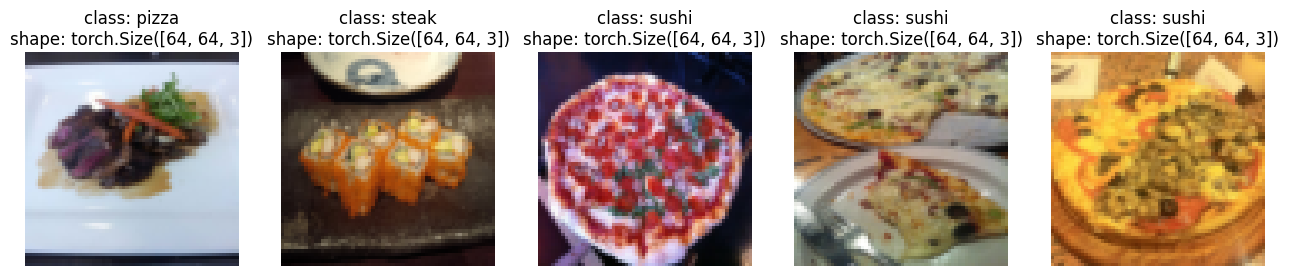

In [ ]:
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=1)

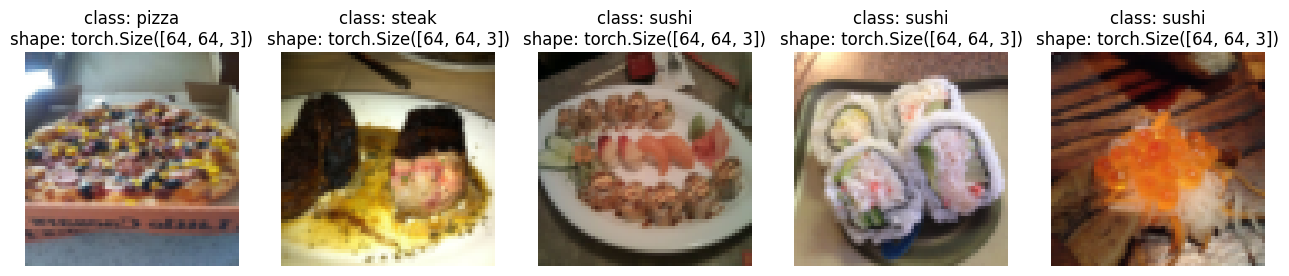

In [ ]:
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=1)

## 5.4 Turn your custom dataset into a `torch.utils.data.DataLoader`

Either with the ImageFolder() object or the custom object, since they are subclassed from `Datasets` they can be used directly with `torch.utils.data.DataLoader` objects

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fca41c94d90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fca41c946a0>)

In [ ]:
# check the shapes of the dataloader thingies

img, lab = next(iter(train_dataloader_custom))
print(f'Img shahpe: {img.shape} -> batch, channel, height, width')
print(f'Label shape: {lab.shape}')

Img shahpe: torch.Size([1, 3, 64, 64]) -> batch, channel, height, width
Label shape: torch.Size([1])


# 6. Other forms of transformations.

Transforms are for altering images before processing. Some transforms:
1. Turning image into a tensor
2. Rotating, cropping, or adding random variation.
3. Augmentation.

*Augmentation* is artificially altering your dataset to increase the diversity of images, which (hopefully) will increase the generalizability of the model. (See documentation on `torchvision.transforms` for examples.)

`TrivialAugment` randomly selects images, and alters the image at a magnitude chosen at random in a given range.

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


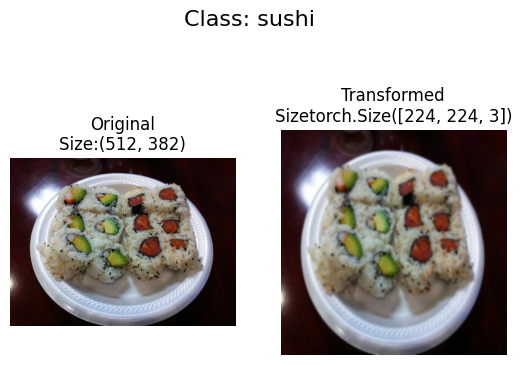

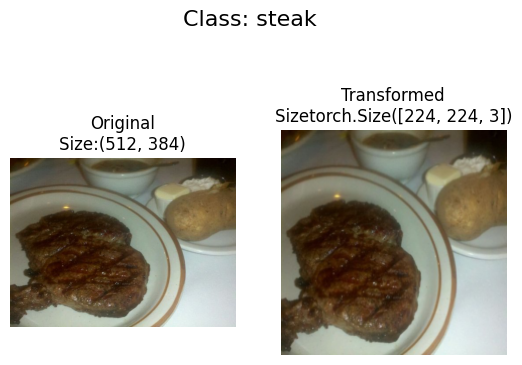

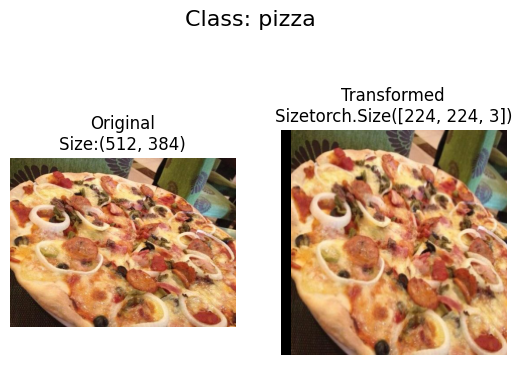

In [ ]:
# test the augmentation

image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# 7. Creating a TinyVGG without data augmentation

Create a computer vision model to classify the images we have organized so far.

Transform images to size (64, 64).

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# form datasets
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

print(f'Creating dataloaders with batch size={BATCH_SIZE} and num_workers={NUM_WORKERS}')

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)




Creating dataloaders with batch size=32 and num_workers=2


## 7.2 Create a TinyVGG model class

This follows the same structure as before, with 2 convolution blocks:
`conv2d->ReLU->conv2d->ReLU->MaxPool2d`

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Image shape:torch.Size([3, 64, 64]) , Label: 2


(-0.5, 63.5, 63.5, -0.5)

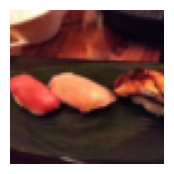

In [ ]:
# Test model by doing forward pass on a single image

img, lab = next(iter(train_dataloader_simple))

img, lab = img[0], lab[0]
print(f'Image shape:{img.shape} , Label: {lab}')
plt.figure(figsize=(2, 2))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')



In [ ]:
model_0.eval()
with torch.inference_mode():
  pred = model_0(img.unsqueeze(dim=0).to(device))

print(f'Output logits:{pred}')
print(f'Output probs: {torch.softmax(pred, dim=1)}\n')
print(f'Output prediction:{torch.argmax(torch.softmax(pred.squeeze(dim=1), dim=1), dim=1)}\n')
print(f'Actual label: {label}')

Output logits:tensor([[0.0578, 0.0634, 0.0352]], device='cuda:0')
Output probs: tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction:tensor([1], device='cuda:0')

Actual label: tensor([0])


## 7.4 Use `torchinfo` to get info on the sizes passing through our model.

`torchinfo` provides information on the sizes of the tensors passing through the model.


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [ ]:
# Write training and testing loop functions

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item() # .item() gets the number not tensor

    # optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # calcualte and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  
  # adjust metrics to get average loss/accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      
      test_pred_logits = model(X)

      # accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # accumulate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
  
  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc





In [ ]:
# Create a train function to combine train_step, test_step

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5):
  
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    print(
        f'Epoch: {epoch+1}|'
        f'train_loss: {train_loss:.4f}|'
        f'train_acc: {train_acc:.4f}|'
        f'test_loss: {test_loss:.4f}|'
        f'test_acc: {test_acc:4f}|'
    )

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set spochs
NUM_EPOCHS = 20

# instantiate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time - start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1078|train_acc: 0.2578|test_loss: 1.1360|test_acc: 0.260417|
Epoch: 2|train_loss: 1.0847|train_acc: 0.4258|test_loss: 1.1620|test_acc: 0.197917|
Epoch: 3|train_loss: 1.1157|train_acc: 0.2930|test_loss: 1.1697|test_acc: 0.197917|
Epoch: 4|train_loss: 1.0955|train_acc: 0.4141|test_loss: 1.1386|test_acc: 0.197917|
Epoch: 5|train_loss: 1.0985|train_acc: 0.2930|test_loss: 1.1429|test_acc: 0.197917|
Total training time: 7.837226687999646


In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
model_0_results['train_loss']

[1.1078328788280487,
 1.0847124308347702,
 1.1157003343105316,
 1.095548078417778,
 1.098489373922348]

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()




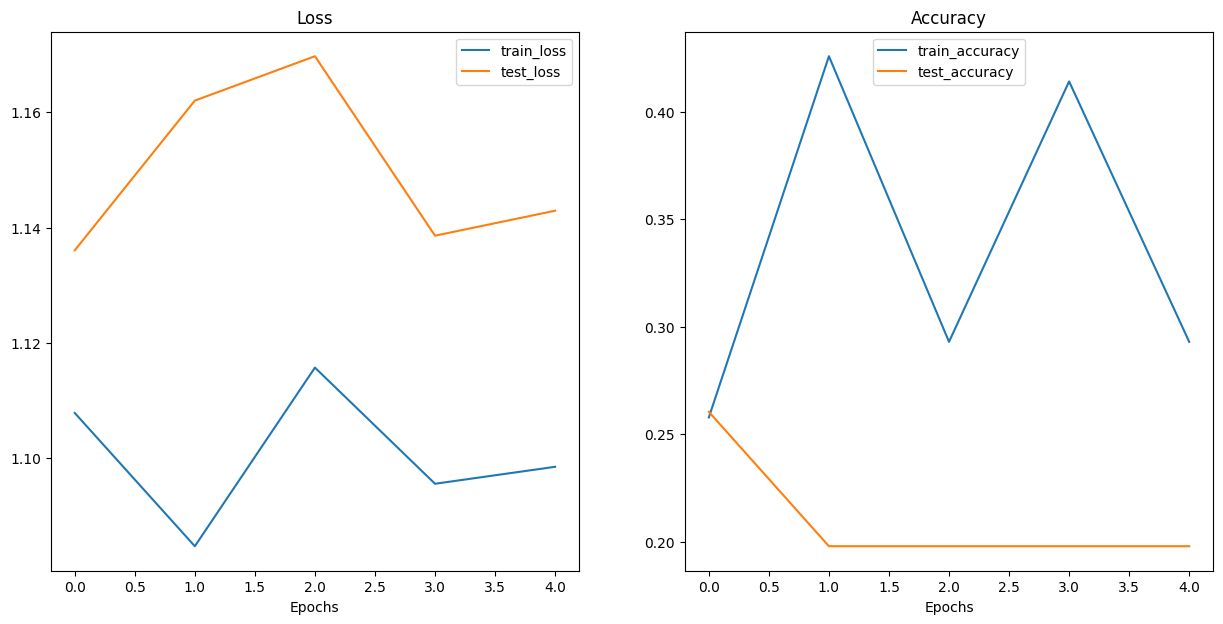

In [ ]:
plot_loss_curves(model_0_results)

## 7.4 Improve results by adding data augmentation

The previous model seems to be underfitting, so try using augmentation to improve it.

In [ ]:
# Create training transform using Trivial Augment.

train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# create new dataloaders with the new transforms
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform_trivial_augment)

In [ ]:
train_data_augmented

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [ ]:
# Now turn the datasets into dataloaders

import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7fc983358eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc983358c70>)

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3, 
    hidden_units=10, 
    output_shape=len(train_data_augmented.classes)
    ).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

from timeit import default_timer as timer

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f'Total training time: {end_time - start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1802|train_acc: 0.2617|test_loss: 1.2151|test_acc: 0.260417|
Epoch: 2|train_loss: 1.1116|train_acc: 0.4258|test_loss: 1.1048|test_acc: 0.260417|
Epoch: 3|train_loss: 1.0915|train_acc: 0.4258|test_loss: 1.1081|test_acc: 0.260417|
Epoch: 4|train_loss: 1.1031|train_acc: 0.3047|test_loss: 1.1127|test_acc: 0.260417|
Epoch: 5|train_loss: 1.0886|train_acc: 0.4258|test_loss: 1.1193|test_acc: 0.260417|
Total training time: 11.110564079000142


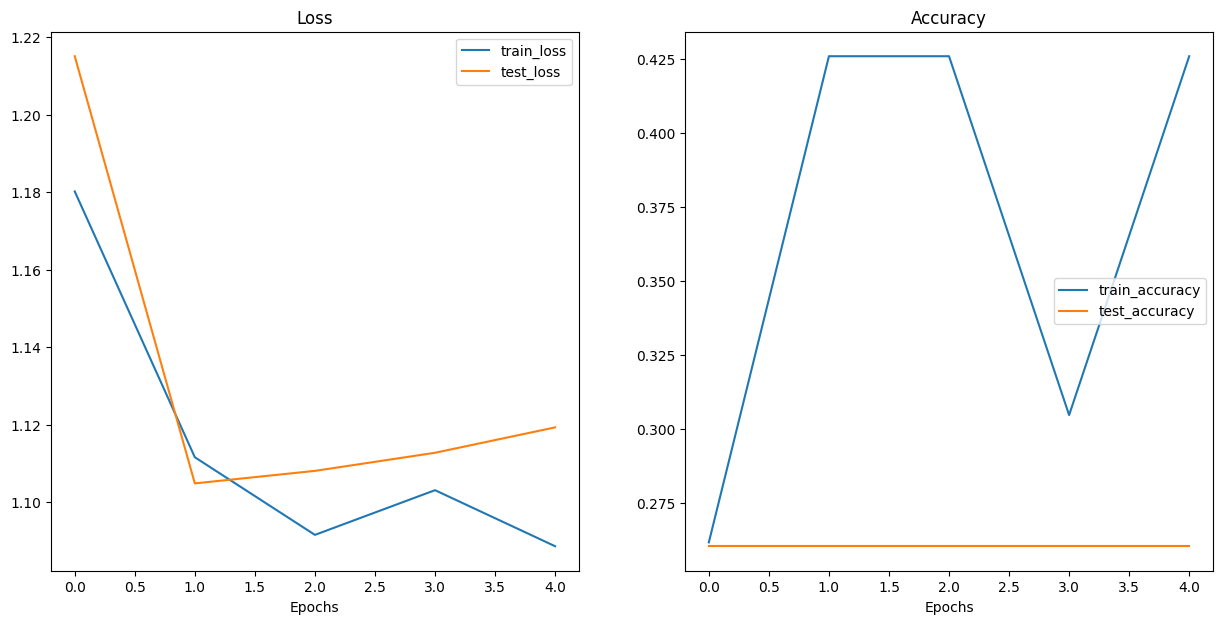

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
# Still not very good, try training for more epochs?

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

from timeit import default_timer as timer

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f'Total training time: {end_time - start_time}')

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)
NUM_EPOCHS = 5

from timeit import default_timer as timer

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f'Total training time: {end_time - start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.0916|train_acc: 0.4258|test_loss: 1.1248|test_acc: 0.260417|
Epoch: 2|train_loss: 1.0879|train_acc: 0.4258|test_loss: 1.1250|test_acc: 0.260417|
Epoch: 3|train_loss: 1.0856|train_acc: 0.4258|test_loss: 1.1289|test_acc: 0.260417|
Epoch: 4|train_loss: 1.1052|train_acc: 0.3047|test_loss: 1.1325|test_acc: 0.260417|
Epoch: 5|train_loss: 1.0849|train_acc: 0.4258|test_loss: 1.1374|test_acc: 0.260417|
Total training time: 10.056140890000279


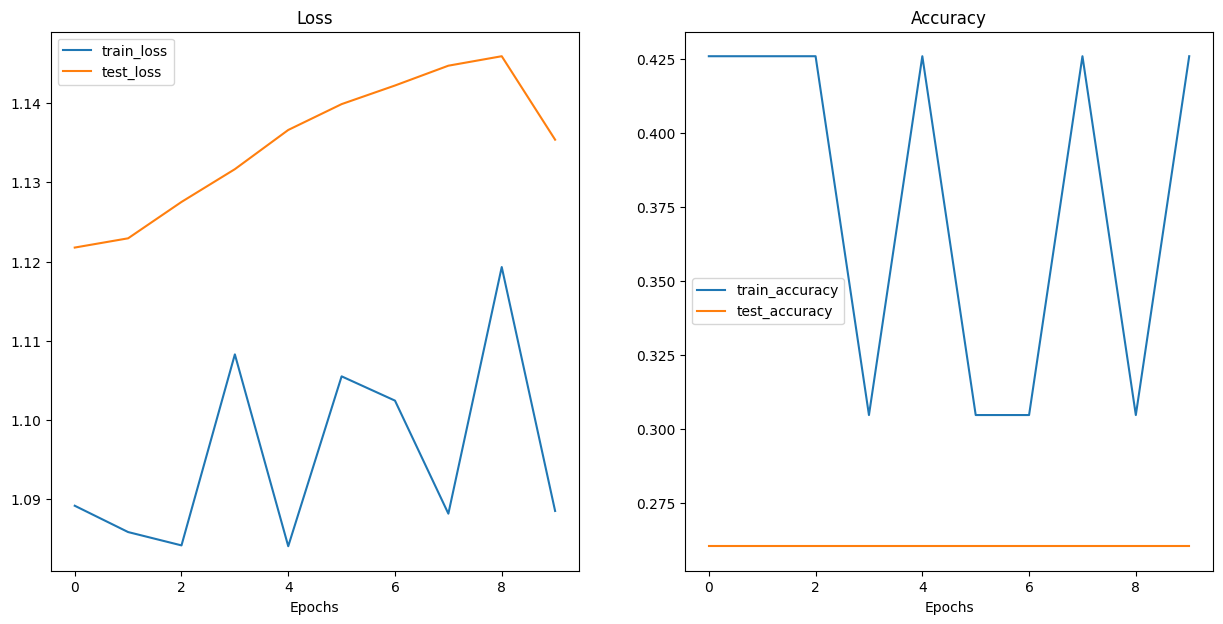

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
# get pandas and compare results from model_0 and model_1

import pandas as pd

model_0_df = pd.DataFrame(model_0_results)

In [ ]:
model_1_df = pd.DataFrame(model_1_results)

In [ ]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084712,0.425781,1.162014,0.197917
2,1.115700,0.292969,1.169714,0.197917
3,1.095548,0.414062,1.138580,0.197917
4,1.098489,0.292969,1.142910,0.197917


In [ ]:
plt.figure(figsize=(17, 12))



plt.subplot(2, 2, 1)
